In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

import keras
import keras.backend as K
from keras.models import Model
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.losses import categorical_crossentropy
from keras.layers import Input, Dense, Dropout, CuDNNGRU, Embedding

Using TensorFlow backend.


In [2]:
train_path = './data/preprocessed/rsc15_train_tr.pkl'
dev_path = './data/preprocessed/rsc15_train_valid.pkl'
test_path = './data/preprocessed/rsc15_test.pkl'
batch_size = 50

train_data = pd.read_pickle(train_path)
#dev_data   = pd.read_pickle(dev_path)
test_data  = pd.read_pickle(test_path)

print('train data shape : ', train_data.shape)
#print('dev data shape : ', dev_data.shape)
print('test data shape : ', test_data.shape)

train data shape :  (31579006, 3)
test data shape :  (71222, 3)


In [3]:
#three백만개
train_data = train_data.head(3000000)
print('train data shape : ', train_data.shape)

train data shape :  (3000000, 3)


In [4]:
train_n_items = len(train_data['ItemId'].unique()) + 1
print('the number of train items : ', train_n_items)

train_samples_qty = len(train_data.SessionId.unique()) + 1
test_samples_qty = len(test_data.SessionId.unique()) + 1

print('the number of train session ID : ', train_samples_qty)
print('the number of test session ID : ', test_samples_qty)

the number of train items :  25456
the number of train session ID :  722918
the number of test session ID :  15325


# dwelling time

In [5]:
from datetime import datetime

In [6]:
train_data.sort_values(['SessionId', 'Time'], inplace = True)

## extract

In [7]:
def compute_dwell_time(df):
   
    times_t = np.roll(df['Time'], -1) # Take time row
    times_dt  = df['Time']            # Copy, then displace by one
    
    diffs = np.subtract(times_t, times_dt) # Take the pairwise difference
    
    length = len(df['ItemId'])
    
    # cummulative offset start for each session
    offset_sessions = np.zeros(df['SessionId'].nunique()+1, dtype=np.int32)
    offset_sessions[1:] = df.groupby('SessionId').size().cumsum() 
    
    offset_sessions = offset_sessions - 1
    offset_sessions = np.roll(offset_sessions, -1)
    
    # session transition implies zero-dwell-time
    # note: paper statistics do not consider null entries, 
    # though they are still checked when augmenting
    np.put(diffs, offset_sessions, np.zeros((offset_sessions.shape)), mode='raise')
        
    return diffs

In [8]:
dts = compute_dwell_time(train_data)

In [9]:
train_data['dwell_time'] = compute_dwell_time(train_data)
train_data.head(3)

,SessionId,ItemId,Time,dwell_time
0,1,214536502,1.396835e+09,180.591
1,1,214536500,1.396836e+09,37.130
2,1,214536506,1.396836e+09,133.308


## statistics

In [10]:
import matplotlib.pyplot as plt

In [11]:
def get_statistics(dts):
    filtered = np.array(list(filter(lambda x: int(x) != 0, dts)))
    pd_dts = pd.DataFrame(filtered)
    pd_dts.boxplot(vert=False, showfliers=False) # no outliers in boxplot
    plt.show()
    print(pd_dts.describe())

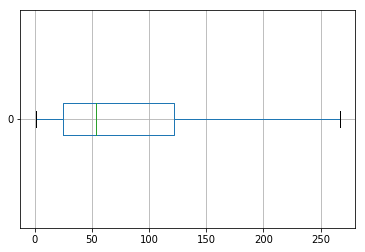

                  0
count  2.248109e+06
mean   1.374777e+02
std    3.044927e+02
min    1.000000e+00
25%    2.463000e+01
50%    5.386900e+01
75%    1.215220e+02
max    5.656584e+03


In [12]:
get_statistics(dts)

# threshold

In [12]:
def join_dwell_reps(df, dt, threshold=20000):
    # Calculate d_ti/threshold + 1
    # then add column to dataFrame
    
    dt //= threshold
    dt += 1   
    df['DwellReps'] = pd.Series(dt.astype(np.int64), index=dt.index)

In [13]:
join_dwell_reps(train_data, dts, threshold = 2000)

In [14]:
train_data.head()

,SessionId,ItemId,Time,dwell_time,DwellReps
0,1,214536502,1.396835e+09,180.591,1
1,1,214536500,1.396836e+09,37.130,1
2,1,214536506,1.396836e+09,133.308,1
3,1,214577561,1.396836e+09,0.000,1
4,2,214662742,1.396847e+09,41.759,1


In [15]:
train_data.DwellReps.value_counts()

1    2983261
2      16737
3          2
Name: DwellReps, dtype: int64

# augment

In [16]:
def augment(df):    
    col_names = list(df.columns.values)[:3]
    print(col_names)
    augmented = np.repeat(df.values, df['DwellReps'], axis=0) 
    print(augmented[0][:3])  
    augmented = pd.DataFrame(data=augmented[:,:3],
                             columns=col_names)
    
    dtype = {'SessionId': np.int64, 
             'ItemId': np.int64, 
             'Time': np.float32}
    
    for k, v in dtype.items():
        augmented[k] = augmented[k].astype(v)
                             
    
    return augmented

In [17]:
train_aug = augment(train_data)
train_aug.head()

['SessionId', 'ItemId', 'Time']
[1.00000000e+00 2.14536502e+08 1.39683547e+09]


,SessionId,ItemId,Time
0,1,214536502,1.396835e+09
1,1,214536500,1.396836e+09
2,1,214536506,1.396836e+09
3,1,214577561,1.396836e+09
4,2,214662742,1.396847e+09


In [18]:
print('train shape : ', train_data.shape)
print('train_aug shape : ', train_aug.shape)

train shape :  (3000000, 5)
train_aug shape :  (3016741, 3)


In [19]:
class SessionDataset :

    """Credit to yhs-968/pyGRU4REC."""
    
    def __init__(self, data, session_key = 'SessionId', item_key = 'ItemId', time_key = 'Time',
                n_samples = -1, itemmap = None, time_sort = False) :
        
        """
        Args:
            path: path of the data file
            session_key, item_key, time_key: name of the fields corresponding to the sessions, items, time
            n_samples: the number of samples to use. If -1, use the whole dataset.
            itemmap: mapping between item IDs and item indices
            time_sort: whether to sort the sessions by time or not
        """
        
        self.df = data
        self.session_key = session_key
        self.item_key = item_key
        self.time_sort = time_sort
        self.add_time_indices(itemmap=itemmap)
        self.df.sort_values([session_key, time_key], inplace = True)
        
        # new method
        self.click_offsets = self.get_click_offsets()
        self.session_idx_arr = self.order_session_idx()
        
    def get_click_offsets(self) :
        
        """
        Return the offsets of the beginning clicks of each session IDs,
        where the offset is calculated against the first click of the first session ID.
        """
        
        offsets = np.zeros(self.df[self.session_key].nunique() + 1, dtype = np.int32)
        offsets[1:] = self.df.groupby(self.session_key).size().cumsum()
        
        return offsets
    
    def order_session_idx(self) :
        """order the session indices"""
        
        if self.time_sort :
            
            session_start_time = self.df.groupby(self.session_key)[self.time_key].min().values
            
            session_idx_arr = np.argsort(session_start_time)
        
        else :
            #0~
            session_idx_arr = np.arange(self.df[self.session_key].nunique())
            
        return session_idx_arr
    
    def add_time_indices(self, itemmap = None) :
        
        if itemmap is None :
            item_ids = self.df[self.item_key].unique() #unique item ids
            item2idx = pd.Series(data = np.arange(len(item_ids)), index = item_ids) # make index
            itemmap = pd.DataFrame({self.item_key : item_ids, 'item_idx' : item2idx[item_ids].values})
            
        self.itemmap = itemmap
        self.df = pd.merge(self.df, self.itemmap, on = self.item_key, how = 'inner')
        
    @property
    def items(self) :
        return self.itemmap.ItemId.unique()

In [20]:
class SessionDataLoader :
    """Credit to yhs-968/pyGRU4REC."""
    def __init__(self, dataset, batch_size = 50) :
        """
        A class for creating session-parallel mini-batches.
        Args:
            dataset (SessionDataset): the session dataset to generate the batches from
            batch_size (int): size of the batch
        """
        
        self.dataset = dataset
        self.batch_size = batch_size
        self.done_sessions_counter = 0
        
        
    def __iter__(self) :
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """
        
        df = self.dataset.df #???????
        session_key = 'SessionId'
        item_key='ItemId'
        time_key='TimeStamp'
        self.n_items = df[item_key].nunique()+1
        click_offsets = self.dataset.click_offsets
        session_idx_arr = self.dataset.session_idx_arr
        
        iters = np.arange(self.batch_size) #batch size
        maxiter = iters.max()
        
        start = click_offsets[session_idx_arr[iters]]
        end = click_offsets[session_idx_arr[iters] + 1]
        mask = []
        
        finished = False
        
        while not finished:
            minlen = (end - start).min()
            # Item indices (for embedding) for clicks where the first sessions start
            idx_target = df.item_idx.values[start]
            for i in range(minlen - 1):
                # Build inputs & targets
                idx_input = idx_target
                idx_target = df.item_idx.values[start + i + 1]
                inp = idx_input
                target = idx_target
                yield inp, target, mask
                
            # click indices where a particular session meets second-to-last element
            start = start + (minlen - 1)
            # see if how many sessions should terminate
            mask = np.arange(len(iters))[(end - start) <= 1]
            self.done_sessions_counter = len(mask)
            for idx in mask:
                maxiter += 1
                if maxiter >= len(click_offsets) - 1:
                    finished = True
                    break
                # update the next starting/ending point
                iters[idx] = maxiter
                start[idx] = click_offsets[session_idx_arr[maxiter]]
                end[idx] = click_offsets[session_idx_arr[maxiter] + 1]

In [21]:
train_n_items = len(train_aug['ItemId'].unique()) + 1
print('the number of train items : ', train_n_items)

train_samples_qty = len(train_aug.SessionId.unique()) + 1
test_samples_qty = len(test_data.SessionId.unique()) + 1

print('the number of train session ID : ', train_samples_qty)
print('the number of test session ID : ', test_samples_qty)

the number of train items :  25456
the number of train session ID :  722918
the number of test session ID :  15325


In [22]:
print('create model...')
emb_size = 50
hidden_units = 100
size = emb_size

inputs = Input(batch_shape=(batch_size, 1, train_n_items))
gru, gru_states = CuDNNGRU(hidden_units, stateful=True, return_state=True)(inputs)
drop2 = Dropout(0.25)(gru)
predictions = Dense(train_n_items, activation='softmax')(drop2)
model = Model(input=inputs, output=[predictions])
opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss=categorical_crossentropy, optimizer=opt)
model.summary()

create model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (50, 1, 25456)            0         
_________________________________________________________________
cu_dnngru_1 (CuDNNGRU)       [(50, 100), (50, 100)]    7667400   
_________________________________________________________________
dropout_1 (Dropout)          (50, 100)                 0         
_________________________________________________________________
dense_1 (Dense)              (50, 25456)               2571056   
Total params: 10,238,456
Trainable params: 10,238,456
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=[<tf.Tenso...)`
  # Remove the CWD from sys.path while we load stuff.


In [23]:
def get_states(model):
    return [K.get_value(s) for s,_ in model.state_updates]

In [24]:
train_dataset = SessionDataset(train_aug)

In [25]:
import gc
gc.collect()

35

In [26]:
def get_metrics(model, train_generator_map, recall_k=20, mrr_k=20):

    test_dataset = SessionDataset(test_data, itemmap=train_generator_map)
    test_generator = SessionDataLoader(test_dataset, batch_size=batch_size)

    n = 0
    rec_sum = 0
    mrr_sum = 0

    with tqdm(total=test_samples_qty) as pbar:
        for feat, label, mask in test_generator:

            target_oh = to_categorical(label, num_classes=train_n_items)
            input_oh  = to_categorical(feat,  num_classes=train_n_items) 
            input_oh = np.expand_dims(input_oh, axis=1)
            
            pred = model.predict(input_oh, batch_size=batch_size)

            for row_idx in range(feat.shape[0]):
                pred_row = pred[row_idx] 
                label_row = target_oh[row_idx]

                rec_idx =  pred_row.argsort()[-recall_k:][::-1]
                mrr_idx =  pred_row.argsort()[-mrr_k:][::-1]
                tru_idx = label_row.argsort()[-1:][::-1]

                n += 1

                if tru_idx[0] in rec_idx:
                    rec_sum += 1

                if tru_idx[0] in mrr_idx:
                    mrr_sum += 1/int((np.where(mrr_idx == tru_idx[0])[0]+1))
            
            pbar.set_description("Evaluating model")
            pbar.update(test_generator.done_sessions_counter)

    recall = rec_sum/n
    mrr = mrr_sum/n
    return (recall, recall_k), (mrr, mrr_k)

In [27]:
def train_model(model, save_weights = False):
    train_dataset = SessionDataset(train_data)
    model_to_train = model
    batch_size = 50

    for epoch in range(5):
        with tqdm(total=train_samples_qty) as pbar:
            loader = SessionDataLoader(train_dataset, batch_size=batch_size)
            for feat, target, mask in loader:
                
                real_mask = np.ones((batch_size, 1))
                for elt in mask:
                    real_mask[elt, :] = 0

                hidden_states = get_states(model_to_train)[0]
                hidden_states = np.multiply(real_mask, hidden_states)
                hidden_states = np.array(hidden_states, dtype=np.float32)
                model_to_train.layers[1].reset_states(hidden_states)

                input_oh = to_categorical(feat, num_classes=loader.n_items) 
                input_oh = np.expand_dims(input_oh, axis=1)

                target_oh = to_categorical(target, num_classes=loader.n_items)

                tr_loss = model_to_train.train_on_batch(input_oh, target_oh)

                pbar.set_description("Epoch {0}. Loss: {1:.5f}".format(epoch, tr_loss))
                pbar.update(loader.done_sessions_counter)
            
        if save_weights:
            print("Saving weights...")
            model_to_train.save('./GRU4REC_3m_{}.h5'.format(epoch))
        
        (rec, rec_k), (mrr, mrr_k) = get_metrics(model_to_train, train_dataset.itemmap)

        print("\t - Recall@{} epoch {}: {:5f}".format(rec_k, epoch, rec))
        print("\t - MRR@{}    epoch {}: {:5f}".format(mrr_k, epoch, mrr))
        print("\n")

In [28]:
train_model(model, False)

Epoch 1. Loss: 6.06081:   0%|          | 173/722918 [00:00<13:29, 892.80it/s]

	 - Recall@20 epoch 0: 0.259795
	 - MRR@20    epoch 0: 0.124156




Epoch 2. Loss: 5.73285:   0%|          | 173/722918 [00:00<13:28, 893.96it/s]

	 - Recall@20 epoch 1: 0.354178
	 - MRR@20    epoch 1: 0.167314




Epoch 3. Loss: 4.68059:   0%|          | 155/722918 [00:00<13:43, 877.15it/s]

	 - Recall@20 epoch 2: 0.382466
	 - MRR@20    epoch 2: 0.182907




Epoch 4. Loss: 5.57372:   0%|          | 173/722918 [00:00<13:23, 899.77it/s]

	 - Recall@20 epoch 3: 0.407877
	 - MRR@20    epoch 3: 0.190875




Evaluating model:   3%|▎         | 521/15325 [00:42<20:01, 12.32it/s]

	 - Recall@20 epoch 4: 0.427123
	 - MRR@20    epoch 4: 0.198652


